# SNA Assignment

## Install Libraries

In [1]:
! pip install networkx
! pip install plotly
! pip install colorlover

In [2]:
import networkx as nx
import pandas as pd
from collections import Counter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

import random

import colorlover as cl
from IPython.display import HTML

import re
import nltk
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tag import PerceptronTagger

from string import printable
import html

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Data

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [0]:
df = pd.read_csv("/content/drive/My Drive/MIE1513/tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

## Q1. Choose a hash-tag

Chosen Hashtag: #bonnaroo

In [0]:
# filtering your dataframe based on the hashtags
bonnarooTag = df[df["tweet"].str.lower().str.contains("#bonnaroo", na=False)].copy()
# remove duplicated tweets
bonnarooTag.drop_duplicates(subset=['date', 'user', 'tweet'], inplace=True)

In [0]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [0]:
addMentionedColumn(bonnarooTag)

In [0]:
bonnarooTag.head()

date  ...        mentioned
1205   2009-06-11 16:59:01  ...               []
5824   2009-06-11 17:08:15  ...    [wfmbonnaroo]
10897  2009-06-11 17:13:24  ...               []
23587  2009-06-11 17:32:10  ...               []
25613  2009-06-11 17:34:55  ...  [hipsterrunoff]

[5 rows x 4 columns]

## Q2. Build a Mention Graph

### (a)

In [0]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
          if len(mentionedUser) == 0:
            pass
          elif mentionedUser == ['']:
            pass
          else:
            if (user in g) and (mentionedUser in g[user]):
              g[user][mentionedUser]["numberMentions"] += 1
            else:
              g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [0]:
bonnarooGraph = mentionGraph(bonnarooTag)   

In [0]:
print("# nodes:", len(bonnarooGraph.nodes()))
print("# edges:", len(bonnarooGraph.edges()))

# nodes: 496
# edges: 458


### (b)

In [0]:
# Code taken from networkx docs: https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html

def gethistogram(G):

  degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
  # print "Degree sequence", degree_sequence
  degreeCount = Counter(degree_sequence)
  deg, cnt = zip(*degreeCount.items())

  fig = plt.figure(figsize=(15,7))
  fig.add_subplot(1,1,1)

  plt.bar(deg, cnt, width=0.80, color='b')

  plt.title("Degree Histogram")
  plt.ylabel("Count")
  plt.xlabel("Degree") 

  plt.show() 

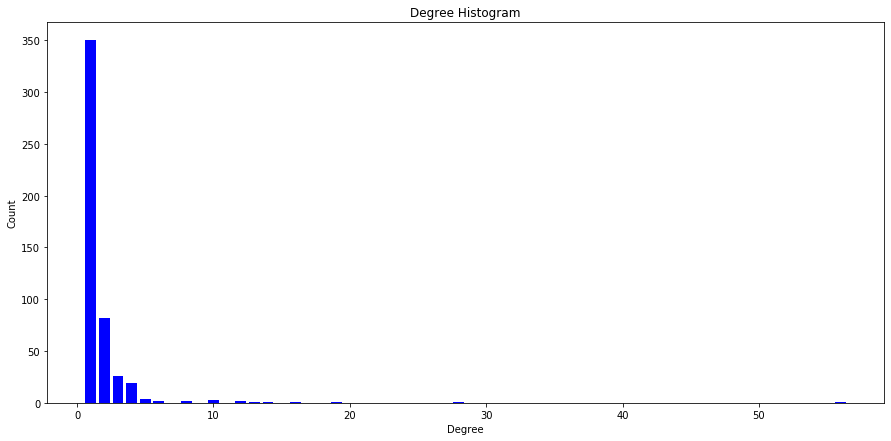

In [0]:
gethistogram(bonnarooGraph)

Very few users have a degree above 4 and a majority of users only have a degree of 1. Users who have a degree above 20 are most likely social media "influencers" who have a larger twitter following than the average user.

### (c)

In [0]:
edge_dict = {}
for node1, node2 in bonnarooGraph.edges():
  edge_dict[(node1, node2)] = bonnarooGraph[node1][node2]['numberMentions']

edgeCounter = Counter(edge_dict) 
edgeCounter.most_common(5) 

[(('musicallies', 'radiobonnaroo'), 5),
 (('radiobonnaroo', 'yemblog'), 5),
 (('bonnaroonews', 'karmakimmie'), 4),
 (('bonnaroonews', 'tourtweet'), 3),
 (('bonnaroonews', 'knoxvilledotcom'), 3)]

### (d)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
addRandomPositions(bonnarooGraph)

In [0]:
#HTML(cl.to_html( cl.scales['9'] ))

In [0]:
# map colour scale to 20 cells
#gnbu = cl.scales['9']['seq']['GnBu']
#gnbu20 = cl.interp(gnbu, 20)
#HTML(cl.to_html(gnbu20))
Spectral = cl.scales['9']['div']['Spectral']
Spectral20 = cl.interp(Spectral, 20)
HTML(cl.to_html(Spectral20))

In [0]:
def plotNetworkColour(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColour = (edgeWidth*3) 
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=Spectral20[edgeColour]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=10,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
def applyLayout(graph, layoutFunc, styleFunc):
    if layoutFunc == "random":
      configure_plotly_browser_state()
      styleFunc(graph)
    else:
      graph2 = graph.copy()
      posDict = layoutFunc(graph2) 
      nx.set_node_attributes(graph2, name="pos", values=posDict)
      configure_plotly_browser_state()
      styleFunc(graph2)

In [0]:
applyLayout(bonnarooGraph, "random", plotNetworkColour)

In [0]:
applyLayout(bonnarooGraph, nx.circular_layout, plotNetworkColour)

In [10]:
from IPython.display import Image, display

display(Image("/content/drive/My Drive/MIE1513/Q2D.png"))

In [11]:
display(Image("/content/drive/My Drive/MIE1513/Q2D-2.png"))

## Q3. Content Analysis

### (a)

In [0]:
# This is a function that I wrote to clean twitter data for an assignment in another course
def TextCleaner(data, colname='tweet'):
    
    # Remove unprintable characters
    data[colname] = data[colname].apply(lambda y: ''.join(filter(lambda x: x in printable, y)))

    #data[colname] = data[colname].apply(lambda y: ''.join([i for i in s if not i.isdigit()]))
    
    # Remove all html tags and attributes
    data[colname] = data[colname].str.replace('<[^<]+?>', '')
    
    # Replace all html character codes with an ASCII equivalent
    data[colname] = data[colname].apply(lambda x: html.unescape(x))
    
    # Remove URLs by removing anything that starts with http
    data[colname] = data[colname].str.replace(r"http\S+", "")
    
    # Remove hashtags symbol - we still want the hashtag because it might give more insight into the sentiment of the tweet
    data[colname] = data[colname].str.replace(r'#', '')
    
    # Remove twitter handles
    data[colname] = data[colname].str.replace(r'(?:@[\w_]+)', '')
    
    # Remove emojis
    data[colname] = data[colname].str.replace(r"""
            (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
            )""", '')
    
    # Put all characters in lowercase
    data[colname] = data[colname].str.lower()
    
    return data

In [0]:
bonnarooTag = TextCleaner(bonnarooTag)

In [0]:
def define_stop_words(stop_list):
  stop = set(stopwords.words('english')) 
  for word in stop_list:
    stop.add(word)

  return stop

In [0]:
stop = define_stop_words(['bonnaroo', 'rt']) 

In [0]:
def count_words(df, col='tweet', k=50):
    #tokenizer = RegexpTokenizer(r'\w{2,}')
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
    counter = Counter()
    for review in df[col]:
      words = tokenizer.tokenize(review.lower())
      counter.update(words)

    # remove stop words from the word count
    for word in stop:
      counter.pop(word, None)

    return counter.most_common(k)

In [0]:
tagger = PerceptronTagger()

# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag

# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

chunker = nltk.RegexpParser(grammar)

In [0]:
# Noun Phrase Extraction Support Functions
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    #word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stop)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
def count_np(df, col='tweet', k=50):
    tokenizer = RegexpTokenizer(r'\w{2,}')
    counter = Counter()
    for review in df[col]:
      counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(tokenizer.tokenize(review)))) 
                            ]))
      
    return counter.most_common(k)

In [0]:
top50np = count_np(bonnarooTag)

In [0]:
top50np

[('beastie boy', 18),
 ('last night', 10),
 ('santa claus', 9),
 ('dirty projector', 8),
 ('passion pit', 7),
 ('david byrne', 7),
 ('al green', 7),
 ('trent reznor', 7),
 ('jimmy buffet', 6),
 ('animal collective', 6),
 ('good advice', 6),
 ('jimmy buffett', 5),
 ('wsj speakeasy coverage', 5),
 ('live stream', 5),
 ('jealous omg', 5),
 ('new stage', 5),
 ('janelle monae', 4),
 ('ferris wheel', 4),
 ('bonnapaste tag', 4),
 ('pastemagazine com homepage', 4),
 ('sonic stage', 4),
 ('grace potter', 4),
 ('yeah yeah yeahs', 4),
 ('main stage', 4),
 ('set list phish ohhhh yea', 4),
 ('incredible experience', 4),
 ('bon iver', 4),
 ('andrew bird', 4),
 ('bruce springsteen', 4),
 ('song badlands', 4),
 ('white rabbit', 3),
 ('first day', 3),
 ('music download', 3),
 ('fructis tent', 3),
 ('twitteroo fuse', 3),
 ('pm ct', 3),
 ('first tweet', 3),
 ('sunny ade', 3),
 ('phish fan', 3),
 ('glow stick', 3),
 ('win lol', 3),
 ('girl talk', 3),
 ('need caption', 3),
 ('gov mule', 3),
 ('hot air ball

I decided to analyze top noun phrases because it made sense for my hashtag that I picked. Most of the top noun phrases are headliner acts for the bonnaroo music festival such as Beastie Boys, Bruce Springsteen, Passion Pit, and Al Green. This makes sense since most people attending the music festival are tweeting about the music artists they're seeing.

### (b)

In [0]:
def plotNetwork(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColour = (edgeWidth*3) 
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=Spectral20[edgeColour]))
        scatters.append(s)

    for node in graph.nodes():
        userdf = bonnarooTag[bonnarooTag['user'] == node]
        userwords=[]
        for word, val in count_np(userdf, k=3):
          userwords.append(word) 
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos],
                text="User: %s\nTop words: %s\n" % (node, userwords), 
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=10,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
applyLayout(bonnarooGraph, "random", plotNetwork)

In [0]:
applyLayout(bonnarooGraph, nx.circular_layout, plotNetwork)


## Q4. Centrality Analysis

### (a)

In [0]:
nx.degree_centrality(bonnarooGraph)

{'#bonnaroo': 0.00202020202020202,
 '1000timesyes': 0.00404040404040404,
 '3sight': 0.00202020202020202,
 '4pm': 0.00202020202020202,
 '50cent': 0.00202020202020202,
 'ac_ent': 0.00202020202020202,
 'adamhk': 0.00404040404040404,
 'adriennebailey': 0.00202020202020202,
 'adrienneroyer': 0.00202020202020202,
 'aikenstandard': 0.00404040404040404,
 'akavirtualpa': 0.00202020202020202,
 'aliastes': 0.00202020202020202,
 'amykross': 0.00404040404040404,
 'amyzulu73': 0.00202020202020202,
 'andyberke': 0.00202020202020202,
 'andygadiel)': 0.00202020202020202,
 'anewmode': 0.00202020202020202,
 'annehaines': 0.00202020202020202,
 'anomolly': 0.00202020202020202,
 'antelope72': 0.00202020202020202,
 'apobrien': 0.00202020202020202,
 'arjbarker': 0.00202020202020202,
 'artfront': 0.00404040404040404,
 'ascharfberg': 0.00202020202020202,
 'ashevillbrewing': 0.00202020202020202,
 'ashlaf': 0.00202020202020202,
 'attmusic': 0.0202020202020202,
 'attmusic)': 0.00404040404040404,
 'austinlouisray':

In [0]:
nx.betweenness_centrality(bonnarooGraph)

{'#bonnaroo': 0.0,
 '1000timesyes': 6.54316443790128e-05,
 '3sight': 0.0,
 '4pm': 0.0,
 '50cent': 0.0,
 'ac_ent': 0.0,
 'adamhk': 0.0,
 'adriennebailey': 0.0,
 'adrienneroyer': 0.0,
 'aikenstandard': 8.1789555473766e-06,
 'akavirtualpa': 0.0,
 'aliastes': 0.0,
 'amykross': 5.725268883163621e-05,
 'amyzulu73': 0.0,
 'andyberke': 0.0,
 'andygadiel)': 0.0,
 'anewmode': 0.0,
 'annehaines': 0.0,
 'anomolly': 0.0,
 'antelope72': 0.0,
 'apobrien': 0.0,
 'arjbarker': 0.0,
 'artfront': 0.0,
 'ascharfberg': 0.0,
 'ashevillbrewing': 0.0,
 'ashlaf': 0.0,
 'attmusic': 0.024061941956678816,
 'attmusic)': 3.27158221895064e-05,
 'austinlouisray': 0.0,
 'azulaco': 0.005912839597050124,
 'backstagephoto': 0.02259027522185417,
 'bal_orioles': 0.0,
 'bandsthatjam': 0.0021019915756757862,
 'bawstonsean': 0.0,
 'beastieboys': 0.029812292970187705,
 'billboarddotcom': 0.04194250194250194,
 'billboarddotcom)': 0.0,
 'bitchbuzz': 0.0,
 'bjr70': 0.0021019915756757862,
 'bla__': 0.0,
 'blithe)': 0.0,
 'blogness'

### (b)

In [0]:
# adding colour and text based on centrality 
def plotNetworkSizeColour(graph, metric):

    if metric == "betweenness":
      centrality = nx.betweenness_centrality(graph)

    if metric == "degree":
      centrality = nx.degree_centrality(graph)

    maxCentr = max(centrality.values())
    minCentr = min(centrality.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)

    for node in graph.nodes():

        if metric == "degree":
          node_size = 3+centrality[node]*200

        else:
          node_size = centrality[node]*100

        nodeCentr = centrality[node]
        nodeColor = int(10*(nodeCentr-minCentr)/(maxCentr-minCentr) + 7)
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nCentrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=Spectral20[nodeColor], 
                    size=node_size,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)
    #size=nx.closeness_centrality(graph,node)*100

In [0]:
configure_plotly_browser_state()
plotNetworkSizeColour(bonnarooGraph, "degree")

In [0]:
configure_plotly_browser_state()
plotNetworkSizeColour(bonnarooGraph,"betweenness") 

### (c)

In [0]:
def func(user):
  if len(bonnarooTag[bonnarooTag['user'] == user]) == 1:
    for mention in bonnarooTag[bonnarooTag['user'] == user].mentioned:
      num_mentions = len(mention) 
    return num_mentions

  else:
    count = 0
    for mentions in bonnarooTag[bonnarooTag['user'] == user].mentioned:
      for mention in mentions:
        count += 1

    return count

def func2(user):
  count = 0
  for mentions in bonnarooTag.mentioned:
    for mention in mentions:
      if mention == user:
        count += 1

  return count

In [0]:
print('number users that are mentioned by bonnaroonews: {}'.format(func('bonnaroonews')))
print('number users that mention bonnaroonews: {}'.format(func2('bonnaroonews')))

number users that are mentioned by bonnaroonews: 17
number users that mention bonnaroonews: 49


In [0]:
print('number users that are mentioned by hourlytechdeals: {}'.format(func('hourlytechdeals')))
print('number users that mention hourlytechdeals: {}'.format(func2('hourlytechdeals')))

number users that are mentioned by hourlytechdeals: 32
number users that mention hourlytechdeals: 0


In [0]:
print('number users that are mentioned by billboarddotcom: {}'.format(func('billboarddotcom')))
print('number users that mention billboarddotcom: {}'.format(func2('billboarddotcom')))

number users that are mentioned by billboarddotcom: 0
number users that mention billboarddotcom: 22


For both betweenness and degree, the key player is bonnaroonews. 

The degree centrality for a node v is the fraction of nodes it is connected to.

The betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v.

It makes sense that the more a twitter user is connected to other users, the more information it brokers between the users. This is why the degree centrality and betweenness centrality match eachother fairly well. 

The main difference is that some users have a larger degree centrality but low betweenness centrality such as hourlytechdeals. This might be because hourlytechdeals mentions 32 other users, but no users mention hourlytechdeals. The user billboarddotcom is the opposite. This user is mentioned by 22 other users, but does not mention any users. This means it also has a higher degree centrality but a lower betweenness. 



## Q5. Connectivity Patterns

### (a)

In [0]:
#The clique number of a graph is the size of the largest clique in the graph.
nx.graph_clique_number(bonnarooGraph)

3

In [0]:
#Returns the number of maximal cliques in the graph
nx.graph_number_of_cliques(bonnarooGraph)

416

### (b)

In [0]:
for clique in list(nx.find_cliques(bonnarooGraph)):
  if len(clique) == 3:
    print(clique)

['desireekoh13', 'springsteen', 'greasylake)']
['desireekoh13', 'springsteen', 'jalynhenton']
['jalynhenton', 'lisajkroll', 'greasylake']
['jalynhenton', 'niketa_h_hill', 'springsteen']
['bonnarooapp', 'backstagephoto', 'harryhoody']
['bruisinales', 'wncwjoe', 'suehuskins']
['h3m3a3', 'gomeztheband', 'playback_cloth']
['fakekarlrove', 'backstagephoto', 'kenpiper']
['harryhoody', 'phish', 'backstagephoto']
['artfront', 'pastemagazine', 'timpaste']
['spinearth', 'kyte', 'myworldmusic']
['evoque', 'ministry92', 'adamhk']
['ohsocali', 'crosbyloggins', 'davelawrence']
['nickjones82', 'billboarddotcom', 'jillmenze']
['lamy13', 'pastemagazine', 'timpaste']
['bonnaroonews', 'playback_cloth', 'tourtweet']
['bonnaroonews', 'kmcurry', 'livemusicblog']
['bonnaroonews', 'kmcurry', 'ourstage']
['bonnaroonews', 'kmcurry', 'tourtweet']
['bonnaroonews', 'kmcurry', 'thebutterroom']
['bonnaroonews', 'kmcurry', 'nugsnet']
['bonnaroonews', 'metromixnash', 'karmakimmie']
['bonnaroonews', 'metromixnash', 'jo

In [0]:
bonnarooTag[bonnarooTag['user'] == 'bonnaroonews'].head()

date  ...                                          mentioned
759381   2009-06-12 10:15:21  ...  [tourtweet, tourtweet, thebutterroom, ourstage...
800679   2009-06-12 11:18:50  ...                                                 []
1113382  2009-06-12 17:23:44  ...                                         [nitweet)]
1146848  2009-06-12 18:03:20  ...                                                 []
1348315  2009-06-12 22:18:24  ...                                         [knoxnews]

[5 rows x 4 columns]

In [0]:
bonnarooTag[bonnarooTag['user'] == 'springsteen']

date  ...                   mentioned
2973337  2009-06-14 12:59:50  ...  [jalynhenton, greasylake)]

[1 rows x 4 columns]

In [0]:
bonnarooTag[bonnarooTag['user'] == 'kmcurry']

date  ...                                          mentioned
1471725  2009-06-13 01:03:57  ...  [tourtweet, tourtweet, thebutterroom, ourstage...

[1 rows x 4 columns]

The largest clique size is only 3. The twitter user bonnaroonews is in the most number of cliques which makes sense as it has the highest centrality values. Bonnaroonews is connected most with music news accounts such as metromixnash, thebutterroom and livemusicblog.
Other users such as springsteen and kmcurry are in more cliques because they retweeted another user's tweet.